In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, kernel_size =5)
        self.fc1 = nn.Linear(6*5*5, 120)
        self.fc2 = nn.Linear(120, 84 )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

def convfc():
    model_arch = Net()
    return model_arch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
%pip install wandb -q
import wandb
# import Fadml_Assignment_model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy

In [6]:
wandb.init(project="pytorch-CIFAR",reinit=True)
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

wandb: Currently logged in as: vatangl14 (use `wandb login --relogin` to force relogin)


In [7]:
device

'cuda'

In [8]:
# Data
print('Data transformation')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Data transformation


In [9]:
validation_split = .2
shuffle_dataset = True
random_seed= 42


trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Creating data indices for training and validation splits:
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128,num_workers=2,sampler=train_sampler)

validationloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, num_workers=2,sampler=valid_sampler)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
trainloader

In [41]:
# #Model
# print('Model creation')
# net =Net()
# net = net.to(device)

Model creation


In [19]:
# Training
def train(epoch,net,criterion,optimizer):
    print('\nEpoch: %d' % epoch)
    net.train()

    running_loss = 0.0
    val_running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Write your code here
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    running_loss_history.append(running_loss)
    #Write training losses to losstrain.txt for each epoch
    ## Creating a dictionary to store the epoch and the losses corresponding to that
    losstrain={'epoch': [epoch],'loss':[running_loss]}
    ## Making a dataframe from this dictionary
    loss_df = pd.DataFrame.from_dict(losstrain)
    ## Making a txt file from this dataframe
    loss_df.to_csv(r'train_loss.txt', header=None, index=None, sep=' ', mode='a')
    print('Finished Training')
    print('Training Loss: %d' % running_loss)
    wandb.log({"Training Loss": running_loss})

    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in validationloader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = net(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
    val_running_loss_history.append(val_running_loss)
    wandb.log({"Validation Loss": val_running_loss})

In [24]:
def test(epoch,net,criterion):
  global best_acc
  net.eval()
  total = 0
  correct = 0
  test_loss = 0
  test_images = []
  print('\nEpoch: %d' % epoch)
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(testloader):
          inputs, targets = inputs.to(device), targets.to(device)
          ## Giving input to the model
          outputs = net(inputs)
          loss = criterion(outputs, targets)
          ## Predicting on the input data
          _, predicted = torch.max(outputs.data, 1)
          ## Defining the total size of the target
          total += targets.size(0)
          ## Getting the total number of correctly classified labels
          test_loss += loss.item()
          correct += (predicted == targets).sum().item()
          ## Appending images to image list
          test_images.append(wandb.Image(inputs[0], caption="Pred: {} Truth: {}".format(predicted[0].item(), targets[0])))
          ## Getting the accuracy of the model
      model_accuracy = 100 * correct / total
      print('Testing Accuracy: %d ' % model_accuracy)
      print('\n')
      ## Checking whether the accuracy is better than the best accuracy
      if model_accuracy>best_acc:
      ## Saving the new value of best_accuracy
        best_acc = model_accuracy
        ## Saving the model
        # Save checkpoint for the model which yields best accuracy
        PATH = './cifar_net.pth'
        torch.save(net.state_dict(), PATH)
          # Write test set losses to losstest.txt for each epoch
      df={'epoch': [epoch],'loss':[test_loss]}
      data = pd.DataFrame.from_dict(df)
      data.to_csv(r'losstest.txt', header=None, index=None, sep=' ', mode='a')
      #Write test set accuracies to acctest.txt for each epoch
      testaccuracy={'epoch': [epoch],'test_accuracy':[model_accuracy]}
      ## Making a dataframe from this dictionary
      accuracy_df = pd.DataFrame.from_dict(testaccuracy)
      ## Making a txt file from this dataframe
      accuracy_df.to_csv(r'test_accuracy.txt', header=None, index=None, sep=' ', mode='a')
      wandb.log({"Testing_images": test_images,"Test Accuracy": 100. * correct / len(testloader.dataset),"Test Loss": test_loss})   
  # Write test set losses to losstest.txt for each epoch

In [25]:
def training_testing(net,criterion,optimizer):
  n_epochs_stop = 20
  epochs_no_improve = 0
  for epoch in range(0,500):
    print("Model Training")
    train(epoch,net,criterion,optimizer)
    if val_running_loss_history[epoch]>val_running_loss_history[epoch-1]:
      if(epochs_no_improve<n_epochs_stop):
        epochs_no_improve+=1
      else:
        break
    else:
      epochs_no_improve=0
    print("\n Model Testing")
    test(epoch,net,criterion)

In [ ]:
run=wandb.init(project="pytorch-CIFAR-Vatan_500",reinit=True)
wandb.watch_called = False # Re-run the model w
net1 = convfc()
wandb.watch(net1,log="all")
net1 = net1.to(device)
running_loss_history = []
val_running_loss_history = []
### Defining a Loss function and optimizer for configuration 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
training_testing(net1,criterion,optimizer)

Training Loss,720.63542
_runtime,16
_timestamp,1622209230
_step,1
Validation Loss,181.61523


Training Loss,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Validation Loss,▁


Model Training

Epoch: 0
Finished Training
Training Loss: 719

 Model Testing

Epoch: 0
Testing Accuracy: 13 


Model Training

Epoch: 1
Finished Training
Training Loss: 704

 Model Testing

Epoch: 1
Testing Accuracy: 22 


Model Training

Epoch: 2
Finished Training
Training Loss: 676

 Model Testing

Epoch: 2
Testing Accuracy: 27 


Model Training

Epoch: 3
Finished Training
Training Loss: 651

 Model Testing

Epoch: 3
Testing Accuracy: 29 


Model Training

Epoch: 4
Finished Training
Training Loss: 611

 Model Testing

Epoch: 4
Testing Accuracy: 33 


Model Training

Epoch: 5
Finished Training
Training Loss: 582

 Model Testing

Epoch: 5
Testing Accuracy: 35 


Model Training

Epoch: 6
Finished Training
Training Loss: 564

 Model Testing

Epoch: 6
Testing Accuracy: 36 


Model Training

Epoch: 7
Finished Training
Training Loss: 547

 Model Testing

Epoch: 7
Testing Accuracy: 39 


Model Training

Epoch: 8
Finished Training
Training Loss: 532

 Model Testing

Epoch: 8
Testing Accuracy

In [ ]:
def predict_with_best_param(net):
  ## Loading the best model parameters 
  PATH ='./cifar_net.pth'
  net.load_state_dict(torch.load(PATH))
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for batch_id, (images, labels) in enumerate(testloader):
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:   
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))

In [ ]:
def confusion_matrix_plot(net):
  total_correct = 0
  total_images = 0
  confusion_matrix = np.zeros([10,10], int)
  with torch.no_grad():
      for batch_id, (images, labels) in enumerate(testloader):
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total_images += labels.size(0)
          total_correct += (predicted == labels).sum().item()
          for i, l in enumerate(labels):
              confusion_matrix[l.item(), predicted[i].item()] += 1 

  model_accuracy = total_correct / total_images * 100
  print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))
  fig, ax = plt.subplots(1,1,figsize=(8,6))
  sns.heatmap(confusion_matrix,annot = True,fmt='d')
  plt.ylabel('Actual Category')
  plt.yticks(range(10), classes)
  plt.xlabel('Predicted Category')
  plt.xticks(range(10), classes)
  plt.show()

In [ ]:
running_loss_history

[484.3179432153702,
 479.0436877012253,
 476.9014000892639,
 473.05411863327026,
 468.1339191198349]

In [ ]:
val_running_loss_history

[120.29618537425995,
 120.35218560695648,
 119.53222262859344,
 117.76254731416702,
 118.70366036891937]

In [ ]:
### Defining a Loss function and optimizer for configuration 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
training_testing()

Training

Epoch: 0
Finished Training
684.7015385627747
Testing

39.88
Training

Epoch: 1
Finished Training
670.8203579187393
Testing

40.78
Training

Epoch: 2
Finished Training
659.5142143964767
Testing

41.88
Training

Epoch: 3
Finished Training
648.096148610115
Testing

43.13
Training

Epoch: 4
Finished Training
637.0372648239136
Testing

44.2


In [ ]:
line_eng = open('/content/train_loss.txt',encoding='utf-8').read().strip().split('\n')

In [ ]:
line_eng

['0 626.3478435277939',
 '1 617.1287066936493',
 '2 608.6173219680786',
 '3 599.8985217809677',
 '4 591.4995070695877']

In [ ]:
## Loading the best model parameters 
PATH ='./cifar_net.pth'
net.load_state_dict(torch.load(PATH))
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for batch_id, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:   
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 50.7 %
Accuracy for class car   is: 75.1 %
Accuracy for class bird  is: 24.8 %
Accuracy for class cat   is: 25.2 %
Accuracy for class deer  is: 36.6 %
Accuracy for class dog   is: 46.6 %
Accuracy for class frog  is: 64.0 %
Accuracy for class horse is: 53.9 %
Accuracy for class ship  is: 69.2 %
Accuracy for class truck is: 51.9 %


In [ ]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for batch_id, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 49.80%


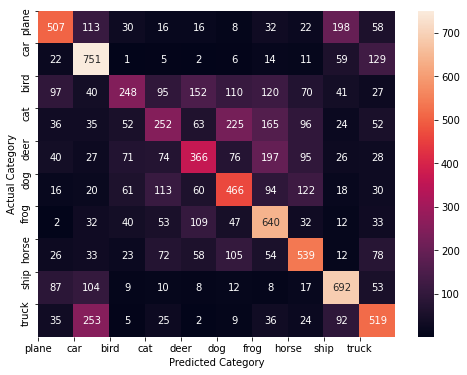

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap(confusion_matrix,annot = True,fmt='d')
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [ ]:
correct_pred

{'bird': 0,
 'car': 0,
 'cat': 0,
 'deer': 0,
 'dog': 0,
 'frog': 0,
 'horse': 0,
 'plane': 0,
 'ship': 0,
 'truck': 0}

In [ ]:
## Defining a resnet model
rn18 = models.resnet18(pretrained=True)
rn18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
## Getting the penultimate layer output so that we can define our own fc from there
input_to_fc=rn18.fc.in_features
rn18.fc = nn.Linear(input_to_fc, 256)
rn18.fc1 = nn.Linear(256,128)
rn18.fc2 = nn.Linear(128,10)

In [ ]:
rn18.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rn18.parameters(), lr=0.01, momentum=0.9)

In [ ]:
rn18 = rn18.to(device)
running_loss_history = []
val_running_loss_history = []
training_testing(rn18,criterion, optimizer)

Model Training

Epoch: 0
Finished Training
Training Loss: 359

 Model Testing

Epoch: 0
Testing Accuracy: 74 


Model Training

Epoch: 1
Finished Training
Training Loss: 238

 Model Testing

Epoch: 1
Testing Accuracy: 77 


Model Training

Epoch: 2
Finished Training
Training Loss: 202

 Model Testing

Epoch: 2
Testing Accuracy: 79 


Model Training

Epoch: 3
Finished Training
Training Loss: 183

 Model Testing

Epoch: 3
Testing Accuracy: 79 


Model Training

Epoch: 4
Finished Training
Training Loss: 169

 Model Testing

Epoch: 4
Testing Accuracy: 81 


Model Training

Epoch: 5
Finished Training
Training Loss: 157

 Model Testing

Epoch: 5
Testing Accuracy: 81 


Model Training

Epoch: 6
Finished Training
Training Loss: 148

 Model Testing

Epoch: 6
Testing Accuracy: 80 


Model Training

Epoch: 7


KeyboardInterrupt: ignored